In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ipywidgets import interact
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Function Definitions

In [2]:
def load_load_data():
    load_history_raw = pd.read_csv("Load_history.csv")
    
    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    load_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    load_data_wide['zone_id'] = load_history_raw['zone_id']
    
    # convert year, month, day columns to one date column
    load_data_wide['date'] = pd.to_datetime(load_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        load_data_wide[col] = load_history_raw[col]
    
    # step 2: unpivoting
    load_data_long = load_data_wide.melt(
        id_vars = ['zone_id', 'date'], # cols to preserve
        value_vars=hour_columns,       # cols to unpivot
        var_name='hour',               # colname for new index col (hour)
        value_name='load'              # colname for new value col (load)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    load_data_long['hour'] = load_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    load_data_long['datetime'] = load_data_long['date'] + pd.to_timedelta(load_data_long['hour'] - 1, unit='h')

    # change dtype on 'load'
    load_data_long['load'] = (
        load_data_long['load']
        .replace(',', '', regex=True)                             # remove commas
        .apply(lambda x: x.strip() if isinstance(x, str) else x)  # strip any whitespace
        .apply(pd.to_numeric, errors='coerce')                    # convert to numeric (keeping NaNs)
    )
    
    # drop extra columns
    load_data_long = load_data_long[['zone_id', 'datetime', 'load']]
    
    return load_data_long

In [3]:
def load_temp_data():
    temp_history_raw = pd.read_csv("temperature_history.csv")
    
    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    temp_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    temp_data_wide['station_id'] = temp_history_raw['station_id']
    
    # convert year, month, day columns to one date column
    temp_data_wide['date'] = pd.to_datetime(temp_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        temp_data_wide[col] = temp_history_raw[col]
    
    # step 2: unpivoting
    temp_data_long = temp_data_wide.melt(
        id_vars = ['station_id', 'date'], # cols to preserve
        value_vars=hour_columns,          # cols to unpivot
        var_name='hour',                  # colname for new index col (hour)
        value_name='temp'                 # colname for new value col (temp)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    temp_data_long['hour'] = temp_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    temp_data_long['datetime'] = temp_data_long['date'] + pd.to_timedelta(temp_data_long['hour'] - 1, unit='h')
    
    # drop extra columns
    temp_data_long = temp_data_long[['station_id', 'datetime', 'temp']]
    
    return temp_data_long

# Analysis

In [4]:
load_data = load_load_data()
temp_data = load_temp_data()

In [5]:
load_data

,zone_id,datetime,load
0,1,2004-01-01 00:00:00,16853.0
1,1,2004-01-02 00:00:00,14155.0
2,1,2004-01-03 00:00:00,14439.0
3,1,2004-01-04 00:00:00,11273.0
4,1,2004-01-05 00:00:00,10750.0
...,...,...,...
791995,20,2008-07-03 23:00:00,NaN
791996,20,2008-07-04 23:00:00,NaN
791997,20,2008-07-05 23:00:00,NaN
791998,20,2008-07-06 23:00:00,NaN


In [6]:
temp_data

,station_id,datetime,temp
0,1,2004-01-01 00:00:00,46.0
1,1,2004-01-02 00:00:00,43.0
2,1,2004-01-03 00:00:00,45.0
3,1,2004-01-04 00:00:00,63.0
4,1,2004-01-05 00:00:00,64.0
...,...,...,...
433747,11,2008-06-26 23:00:00,72.0
433748,11,2008-06-27 23:00:00,71.0
433749,11,2008-06-28 23:00:00,71.0
433750,11,2008-06-29 23:00:00,70.0


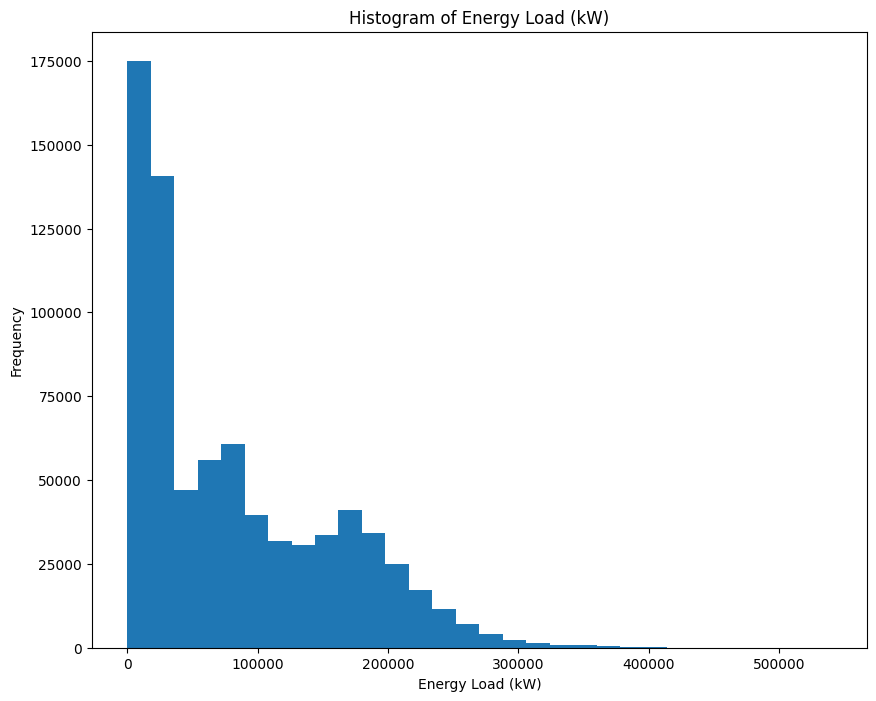

In [7]:
plt.figure(figsize=(10, 8))
plt.hist(load_data['load'], bins=30)
plt.title('Histogram of Energy Load (kW)')
plt.xlabel('Energy Load (kW)')
plt.ylabel('Frequency')
plt.show()

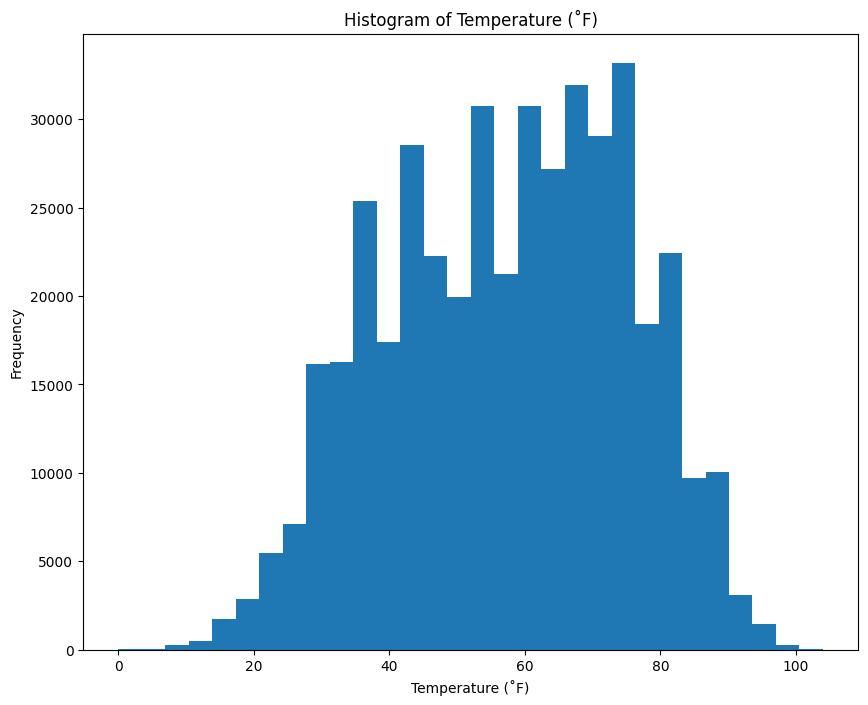

In [8]:
plt.figure(figsize=(10, 8))
plt.hist(temp_data['temp'], bins=30)
plt.title('Histogram of Temperature (˚F)')
plt.xlabel('Temperature (˚F)')
plt.ylabel('Frequency')
plt.show()

## Decomposition
Let's decompose this data to look for seasonal components and the like.

In [9]:
def decompose(data, val_column, periods, plot=False, full=False, raw=False):
    
    data_clean = data.dropna().copy() # cannot have NaNs
    results = {}
    
    for period in periods:

        # step 1: run decomp
        decomp = seasonal_decompose(
            data_clean[val_column],
            model='additive',
            period=period
        )
        results[period] = decomp
        
        # step 2: add data to table
        if full:
            data_clean[f'trend_{period}'] = decomp.trend
        data_clean[f'seasonal_{period}'] = decomp.seasonal
        if full:
            data_clean[f'resid_{period}'] = decomp.resid
        
    # step 3: plot
    if plot:
        def plot_fn(window):
            plt.figure(figsize=(10, 8))
            results[window].plot()
            plt.show()
        interact(plot_fn, window=periods);

    # return
    if raw:
        return data_clean, results
    else:
        return data_clean

def seasonal_rename (data, period_names, full=False):
    drop_cols = []
    for period, name in period_names.items():
        data[f'seasonal_{name}'] = data[f'seasonal_{period}']
        drop_cols.append(f'seasonal_{period}')
        if full:
            data[f'trend_{name}'] = data[f'trend_{period}']
            data[f'resid_{name}'] = data[f'resid_{period}']
            drop_cols.append(f'trend_{period}')
            drop_cols.append(f'resid_{period}')
    return data.drop(columns=drop_cols)

def raw_decomp_rename (decomp, periods_dict):
    result = {}
    for key, val in periods_dict.items():
        result[val] = decomp[key]
    return result

def pretty_decomp(data, val_column, periods_dict, plot=False, full=False, raw=False):
    p_nums = list(periods_dict.keys())
    decomp = pd.DataFrame()
    if plot or raw:
        decomp, plot_data = decompose(
            data=data,
            val_column=val_column,
            periods=p_nums,
            plot=False,
            full=full,
            raw=True
        )
        plot_data = raw_decomp_rename(plot_data, periods_dict)
        decomp = seasonal_rename(decomp, periods_dict, full)
        if plot:
            p_names = list(periods_dict.values())
            def plot_fn(window):
                plt.figure(figsize=(10, 8))
                plot_data[window].plot()
                plt.show()
            interact(plot_fn, window=p_names);
        if raw:
            return decomp, plot_data
        
    else:
        decomp = decompose(
            data=data,
            val_column=val_column,
            periods=p_nums,
            full=full
        )
        decomp = seasonal_rename(decomp, periods_dict, full)
    
    return decomp

In [10]:
load_decomp = pretty_decomp(
    load_data,
    'load',
    {
        24: 'day',
        168: 'week',
        720: 'month',
        8760: 'year'
    },
    plot=True,
    full=True
)

interactive(children=(Dropdown(description='window', options=('day', 'week', 'month', 'year'), value='day'), O…

In [11]:
temp_decomp = pretty_decomp(
    temp_data,
    'temp',
    {
        24: 'day',
        168: 'week',
        720: 'month',
        8760: 'year'
    },
    plot=True,
    full=True
)

interactive(children=(Dropdown(description='window', options=('day', 'week', 'month', 'year'), value='day'), O…

## Correlating! Again!

### Decomposing within zones
Hopefully this will increase accuracy

In [12]:
load_g = load_data.groupby('zone_id')
temp_g = temp_data.groupby('station_id')

windows = {
    24: 'day',
    168: 'week',
    720: 'month',
    8760: 'year'
}

zones = {}
z_plots = {}
stations = {}
s_plots = {}

for zone in load_g.groups:
    zone_g = load_g.get_group(zone)
    g_decomp, g_plot = pretty_decomp(
        zone_g,
        'load',
        windows,
        full=True,
        raw=True
    )
    zones[zone] = g_decomp
    z_plots[zone] = g_plot
def zone_plot(zone, window):
    plt.figure(figsize=(10, 8))
    z_plots[zone][window].plot()
    plt.show()
interact(zone_plot, zone=z_plots.keys(), window=windows.values()) 

for station in temp_g.groups:
    station_g = temp_g.get_group(station)
    g_decomp, g_plot = pretty_decomp(
        station_g,
        'temp',
        windows,
        full=True,
        raw=True
    )
    stations[station] = g_decomp
    s_plots[station] = g_plot
def station_plot(station, window):
    plt.figure(figsize=(10, 8))
    s_plots[station][window].plot()
    plt.show()
interact(station_plot, station=s_plots.keys(), window=windows.values()) 

interactive(children=(Dropdown(description='zone', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

interactive(children=(Dropdown(description='station', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), D…

<function __main__.station_plot(station, window)>

In [13]:
mappings = []

for zone, zone_g in zones.items():
    for station, station_g in stations.items():
        merged_data = zone_g.join(station_g, how='inner', lsuffix='_zone', rsuffix='_station')
        merged_data = merged_data.dropna()

        corr = zone_g[f"load"].corr(station_g[f"temp"])

        new_row = {
            "zone_id": zone,
            "station_id": station,
            "corr": corr
        }

        mappings.append(new_row)
        
mapping_mtx = pd.DataFrame(mappings)

mapping_mtx['zone_id'] = mapping_mtx['zone_id'].astype("int64")
mapping_mtx['station_id'] = mapping_mtx['station_id'].astype("int64")

mapping_mtx

,zone_id,station_id,corr
0,1,1,-0.220935
1,1,2,-0.194908
2,1,3,0.379426
3,1,4,0.349486
4,1,5,-0.173089
...,...,...,...
215,20,7,0.469346
216,20,8,-0.037555
217,20,9,0.071422
218,20,10,-0.002396


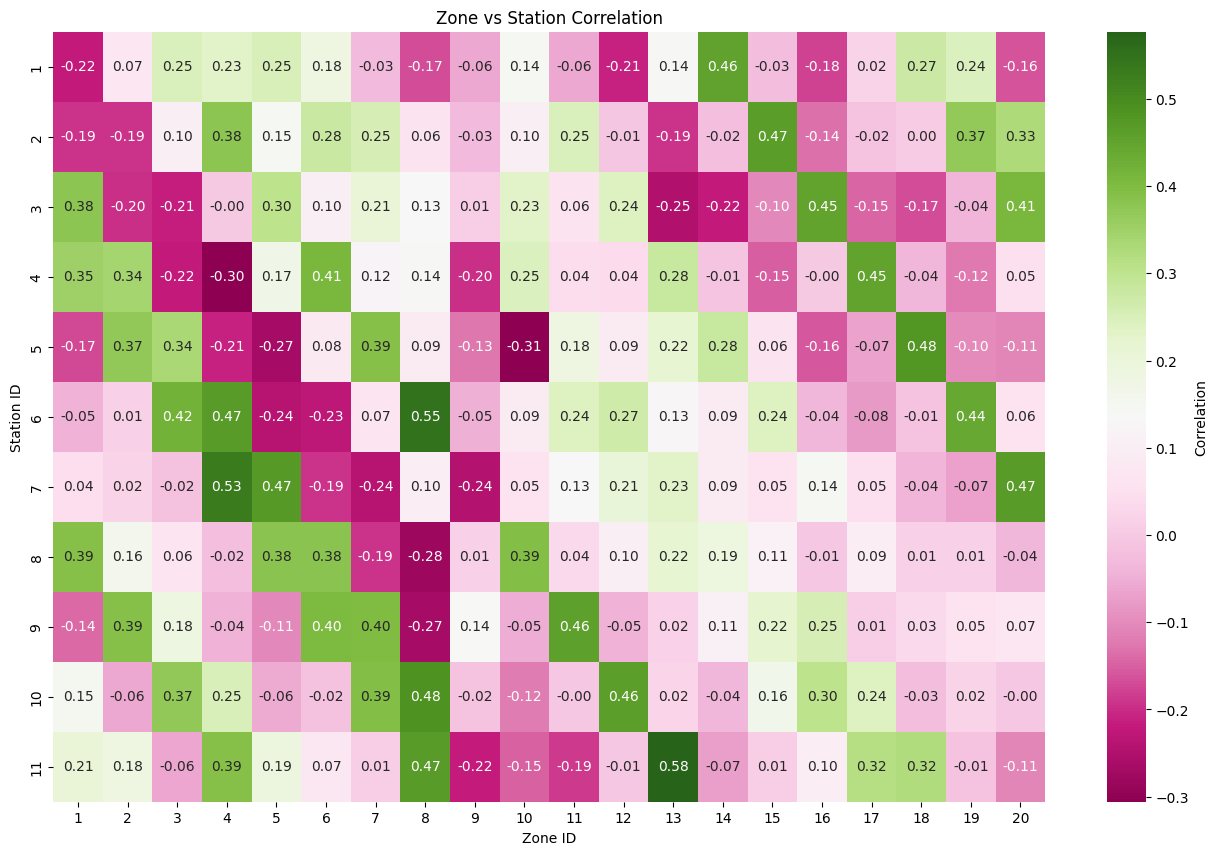

In [14]:
map_mtx_show = mapping_mtx.pivot(index="station_id", columns="zone_id", values="corr")
    
plt.figure(figsize=(16, 10))
sns.heatmap(map_mtx_show, annot=True, cmap="PiYG", fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title("Zone vs Station Correlation")
plt.ylabel("Station ID")
plt.xlabel("Zone ID")
plt.show()

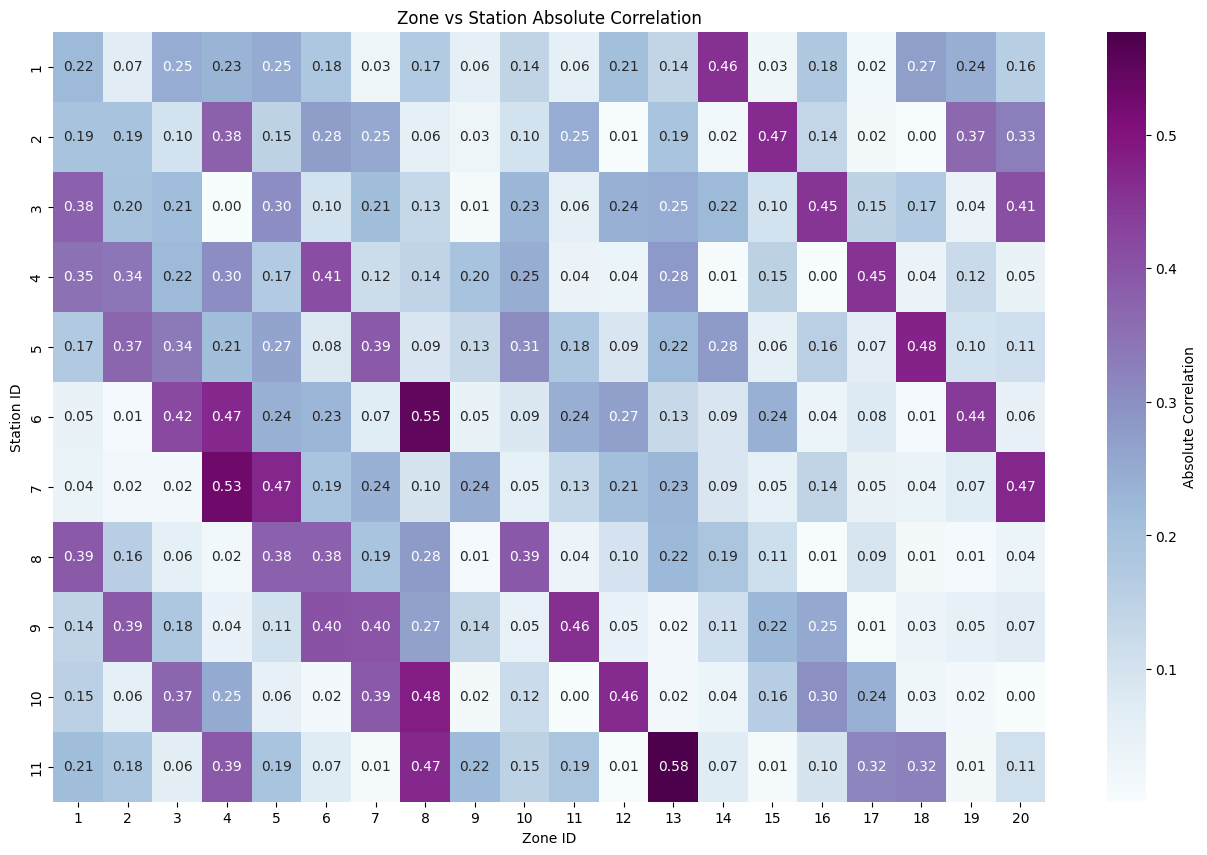

In [15]:
mapping_mtx['abs_corr'] = np.abs(mapping_mtx['corr'])

map_mtx_show = mapping_mtx.pivot(index="station_id", columns="zone_id", values="abs_corr")
    
plt.figure(figsize=(16, 10))
sns.heatmap(map_mtx_show, annot=True, cmap="BuPu", fmt=".2f", cbar_kws={'label': 'Absolute Correlation'})
plt.title("Zone vs Station Absolute Correlation")
plt.ylabel("Station ID")
plt.xlabel("Zone ID")
plt.show()

In [16]:
threshold = np.round(np.max(mapping_mtx['abs_corr']), 2)
num_needed = 19 # this number is selected because zone 9 is an outlier, a conclusion drawn from the by-zone Data/Trend/Season/Resid graph 
                # above, as well as a significant (+0.6) increase in lower bound when 10 is removed. As both of these zones have max
                # correlation with station 9, that can be assumed the most suitable mapping for zones 9 and 10.

final_mapping = mapping_mtx[mapping_mtx['abs_corr'] >= threshold]
# print(f"trying threshold {threshold}, nunique={final_mapping['zone_id'].nunique()}")

while (final_mapping['zone_id'].nunique() < num_needed):
# while (final_mapping['station_id'].nunique() < 11):
    threshold = np.round(threshold - 0.01, 2)
    
    if threshold < 0:  # Safeguard to avoid infinite loop
        print("Threshold dropped below 0, stopping loop.")
        break
    
    final_mapping = mapping_mtx[mapping_mtx['abs_corr'] >= threshold]
    # print(f"trying threshold {threshold}, nunique={final_mapping['zone_id'].nunique()}")
print(f'final threshold: {threshold}')
print(f"total zones captured: {final_mapping['zone_id'].nunique()}")
print(f"total stations used: {final_mapping['station_id'].nunique()}")

final_mapping = final_mapping.groupby('zone_id')

for zone in final_mapping.groups:
    g = final_mapping.get_group(zone)
    print(f"Zone: {zone:2d} Stations: {[x for x in g['station_id']]}")

final threshold: 0.38
total zones captured: 19
total stations used: 11
Zone:  1 Stations: [8]
Zone:  2 Stations: [9]
Zone:  3 Stations: [6]
Zone:  4 Stations: [6, 7, 11]
Zone:  5 Stations: [7, 8]
Zone:  6 Stations: [4, 8, 9]
Zone:  7 Stations: [5, 9, 10]
Zone:  8 Stations: [6, 10, 11]
Zone: 10 Stations: [8]
Zone: 11 Stations: [9]
Zone: 12 Stations: [10]
Zone: 13 Stations: [11]
Zone: 14 Stations: [1]
Zone: 15 Stations: [2]
Zone: 16 Stations: [3]
Zone: 17 Stations: [4]
Zone: 18 Stations: [5]
Zone: 19 Stations: [6]
Zone: 20 Stations: [3, 7]


# Modelling

Goal: to use mappings stored in ```final_mapping``` to model relationships between zones and station

In [17]:
models = {}

for zone, s_list in final_mapping:
    z_data = zones[zone] #[['load', 'seasonal_day', 'seasonal_week', 'seasonal_month', 'seasonal_year']]
    zone_models = {}
    
    if z_data.index.dtype != 'datetime64[ns]':
        z_data.set_index('datetime', inplace=True)
    # print(z_data)
    
    for station in s_list['station_id']:
        s_data = stations[station] #[['temp', 'seasonal_day', 'seasonal_week', 'seasonal_month', 'seasonal_year']]
        if s_data.index.dtype != 'datetime64[ns]':
            s_data.set_index('datetime', inplace=True)
        # print(s_data)

        merged_data = z_data.join(s_data, how='inner', lsuffix='_zone', rsuffix='_station')
        merged_data = merged_data.dropna()
        merged_data['datetime_r'] = (merged_data.index - merged_data.index.min()) / np.timedelta64(1, 'D')
        # print(merged_data.columns)

        y = merged_data['load']
        X = merged_data[['temp', 'datetime_r']]

        model = sm.OLS(y, X).fit()
        zone_models[station] = model

        # print(model.summary())
    models[zone] = zone_models

# LSTM CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
)
from tensorflow.keras.layers import Lambda

In [19]:
# define shape of input
sequence_length = 100 # Number of timesteps in the sequence
feature_dim = 10  # Number of features in each timestep
input_shape = (sequence_length, feature_dim)

# construct input layer
inputs = Input(shape=input_shape)

In [20]:
# construct CNN layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)

In [25]:
# Define a Lambda layer to reshape the CNN output for LSTM
lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(cnn)

# construct LSTM layers
lstm = LSTM(64, return_sequences=False)(lstm_input)

In [26]:
# Fully connected layers
dense = Dense(128, activation='relu')(lstm)
dense = Dropout(0.5)(dense)
outputs = Dense(1, activation='sigmoid')(dense)  # For binary classification

In [27]:
# Build and compile the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1, 3136)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,889 (3.17 MB)

 Trainable params: 829,889 (3.17 MB)

 Non-trainable params: 0 (0.00 B)